# TODO: 
    - Separate CSV into both a testing and a training set. Reserve about 20% for testing, rest is training data. Do this within a function where whole loaded dataframe is shuffled and then 20% of rows are dropped into testing set\
    - Train NN using dataloader and csv data

In [1]:
# Pytorch Imports
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from torch import optim
import torch.nn.functional as F

# Dataframe imports
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Function to generate two csv files for training/testing
def generate_train_test_data(file_name, percent_test=0.2):
    ''' 
        Will divide a dataset into both test and training sets
        
        Args:
        
        file_name (string): path to the csv file containing all data
        percent_test (float): percentage of dataset to set aside for testing
        
        returns nothing
    '''
    # Open file and place into dataframe
    columns = ['open', 'high', 'low', 'close', 'volume', 'prior_high', '50ma']
    stock_data = pd.read_csv(file_name)[columns]
    stock_data['next_close'] = stock_data['close'].shift(-1)
    stock_data = stock_data.dropna()
    
    # Shuffle data and reserve amount for testing
    shuffled = shuffle(stock_data)
    test_end_idx = int(shuffled.shape[0] * percent_test)
    test_data = shuffled.iloc[0:test_end_idx]
    train_data = shuffled.iloc[test_end_idx+1:]
    
    # Save test and train data to files
    prefix_idx = file_name.find('.')
    prefix = file_name[:prefix_idx]
    test_data.to_csv('{0}_test.csv'.format(prefix), index=False)
    train_data.to_csv('{0}_train.csv'.format(prefix), index=False)
    
    print('Saved {0} testing and training files'.format(prefix))
    
    

In [3]:
# Create a dataset class to hold stock data and a transform class to turn ndarrays into tensors
class StockDataset(Dataset):
    '''Dataset for stock data'''
    def __init__(self, csv_file, transform=None):
        '''
        Args:
            csv_file (string): path to the csv file holding the stock data
        '''
        # In actuality we'll ensure that csv file is cleaned properly beforehand
        self.stock_data = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.stock_data)
    
    def __getitem__(self, idx):
        data = self.stock_data.iloc[idx,:-1].as_matrix().astype('float')
        label = pd.Series([self.stock_data.iloc[idx,-1]]).as_matrix().astype('float')
        item = {'data': data, 'label': label}
        
        if self.transform:
            item = self.transform(item)
            
        
        return item
        
class ToTensor(object):
    '''Converts ndarrays to tensors'''
    def __call__(self, sample):
        return {
                'data': torch.from_numpy(sample['data']).type(torch.FloatTensor),
                'label': torch.from_numpy(sample['label']).type(torch.FloatTensor)
                }
        

In [4]:
# Create our test and training data files
generate_train_test_data('chart_data-csv/aapl.csv')

# Create our test/train datasets and load into dataloaders
trainset = StockDataset(csv_file='/aapl_train.csv', transform=transforms.Compose([ToTensor()]))
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = StockDataset(csv_file='/aapl_test.csv', transform=transforms.Compose([ToTensor()]))
testloader = DataLoader(testset, batch_size=32, shuffle=True)

Saved chart_data-csv/aapl testing and training files


FileNotFoundError: File b'aapl_train.csv' does not exist

In [37]:
# Define our network structure
class PricePredictNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define our layer structure
        self.fc1 = nn.Linear(7, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        
        # Add dropout capability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Flatten tensor
        x = x.view(x.shape[0], -1)
        
        # Feed forward
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        #Output layer -- no dropout
        x = F.tanh(self.fc3(x))
        
        return x

In [ ]:
# Define training/validation loop
model = PricePredictNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

epochs = 250
train_losses = []
test_losses = []

# Train and Validate network
for e in range(epochs):
    train_loss = 0
    for sample in trainloader:
        # Get data and labels from sample
        data = sample['data']
        labels = torch.transpose(sample['label'],0,1)
        
        # Reset our gradiants
        optimizer.zero_grad()
        
        # Feed forward
        output = model(data)
        
        # Loss
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        # Tally up loss
        train_loss += loss.item()
    else:
        # Validation step
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for sample in testloader:
                # Get data and labels from sample
                test_data = sample['data']
                labels = torch.transpose(sample['label'],0,1)
                
                # Run model
                output = model(test_data)
                
                # Calculate loss
                loss = criterion(output, labels)
                test_loss += loss.item()
        
        # Record loss values
        train_losses.append(train_loss/len(trainset))
        test_losses.append(test_loss/len(testset))
        
        # Set model back to training mode to include dropout
        model.train()
    
    if(e%10 == 0):
        print('Epoch {0}\n-----------------'.format(str(e+1)))
        print('Training Loss: {0}'.format(train_losses[e]))
        print('Testing Loss: {0}\n'.format(test_losses[e]))

E:\Anaconda\envs\nn\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
E:\Anaconda\envs\nn\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch 1
-----------------
Training Loss: 277.5007578267267
Testing Loss: 296.2893920898438

Epoch 11
-----------------
Training Loss: 282.14198161908166
Testing Loss: 292.9519775390625

Epoch 21
-----------------
Training Loss: 280.46226109277444
Testing Loss: 295.8361409505208

Epoch 31
-----------------
Training Loss: 283.9180800232505
Testing Loss: 291.9867655436198

Epoch 41
-----------------
Training Loss: 282.88078671712407
Testing Loss: 289.6187377929688

Epoch 51
-----------------
Training Loss: 277.8263753678622
Testing Loss: 293.8086385091146

Epoch 61
-----------------
Training Loss: 279.60333321816466
Testing Loss: 292.3936401367188

Epoch 71
-----------------
Training Loss: 284.48130558581556
Testing Loss: 289.23011678059896

Epoch 81
-----------------
Training Loss: 286.077060028616
Testing Loss: 294.747890218099

Epoch 91
-----------------
Training Loss: 288.0447577596579
Testing Loss: 293.3322041829427

Epoch 101
-----------------
Training Loss: 282.04216900526797
Testi

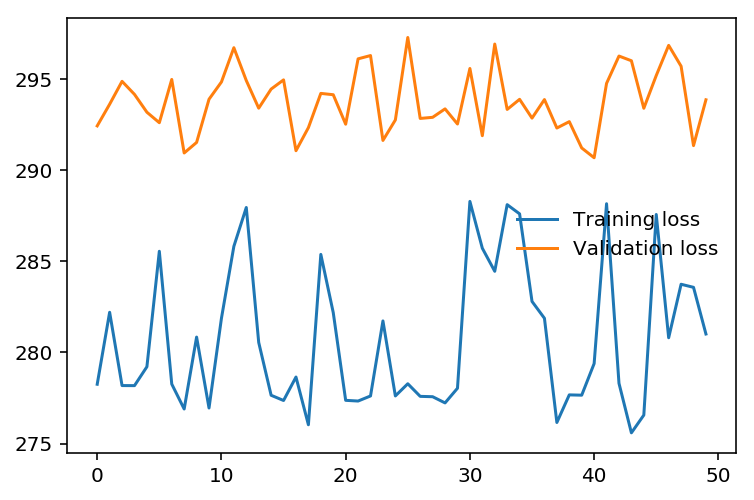

In [35]:
# Plot performance of the training
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [36]:
# Network Stats
avg_train_loss = np.mean(train_losses)
avg_test_loss = np.mean(test_losses)
print('Average Training Loss: {0}'.format(avg_train_loss))
print('Average Testing Loss: {0}'.format(avg_test_loss))

Average Training Loss: 280.6661372075393
Average Testing Loss: 293.80413895670574
